# Day 47 | 通道注意力（SE 注意力）


## 学习目标
> - 回顾注意力机制与通道注意力的定位
> - 训练基线 CNN，并可视化各卷积层特征图
> - 插入 SE 通道注意力模块，观察精度变化
> - 通过热力图理解模型关注的区域

## 1. 注意力回顾
- **注意力本质**：对特征加权求和，权重随输入动态变化（卷积权重是固定的）。
- **为何有多种注意力**：任务需求不同，通道/空间/自注意力等各司其职；计算成本与灵活性需要折衷。
- **通道注意力定位**：在“普通注意力”家族，目标是让模型知道“哪些通道更重要”，常与 CNN 配合使用。

## 2. 基线 CNN：数据与训练流程
1) 数据增强（训练集）+ 规范化（测试集）
2) 构建 CIFAR-10 DataLoader
3) 定义三层卷积的轻量 CNN
4) 训练 50 epoch，记录准确率/损失
5) 抽取中间层特征图便于可视化

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda


In [3]:
# 数据增强：让模型更鲁棒
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 测试集只做规范化，保持分布一致
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = ['飞机', '汽车', '鸟', '猫', '鹿', '狗', '青蛙', '马', '船', '卡车']

In [4]:
class CNN(nn.Module):
    """基线三层卷积 CNN，用作消融对比"""
    def __init__(self):
        super().__init__()
        # 卷积块 1：保持尺寸，提取低级纹理
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        # 卷积块 2：更深的纹理与局部组合
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        # 卷积块 3：抽象语义
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)

        # 分类头
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.relu3(self.fc1(x)))
        return self.fc2(x)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

开始训练基线 CNN...
Epoch 1/50 | Batch 100/782 | 损失: 1.5795
Epoch 1/50 | Batch 200/782 | 损失: 1.1964
Epoch 1/50 | Batch 300/782 | 损失: 1.5032
Epoch 1/50 | Batch 400/782 | 损失: 1.3054
Epoch 1/50 | Batch 500/782 | 损失: 1.3953
Epoch 1/50 | Batch 600/782 | 损失: 1.4067
Epoch 1/50 | Batch 700/782 | 损失: 1.1457
Epoch 1/50 完成 | 训练 Acc: 49.12% | 测试 Acc: 58.49%
Epoch 2/50 | Batch 100/782 | 损失: 1.2697
Epoch 2/50 | Batch 200/782 | 损失: 1.4193
Epoch 2/50 | Batch 300/782 | 损失: 1.0323
Epoch 2/50 | Batch 400/782 | 损失: 1.2884
Epoch 2/50 | Batch 500/782 | 损失: 1.2777
Epoch 2/50 | Batch 600/782 | 损失: 1.1859
Epoch 2/50 | Batch 700/782 | 损失: 1.3310
Epoch 2/50 完成 | 训练 Acc: 54.36% | 测试 Acc: 66.58%
Epoch 3/50 | Batch 100/782 | 损失: 1.2491
Epoch 3/50 | Batch 200/782 | 损失: 1.0914
Epoch 3/50 | Batch 300/782 | 损失: 1.0224
Epoch 3/50 | Batch 400/782 | 损失: 1.2061
Epoch 3/50 | Batch 500/782 | 损失: 1.0037
Epoch 3/50 | Batch 600/782 | 损失: 1.2494
Epoch 3/50 | Batch 700/782 | 损失: 0.9814
Epoch 3/50 完成 | 训练 Acc: 57.80% | 测试 Acc: 66.59%
Ep

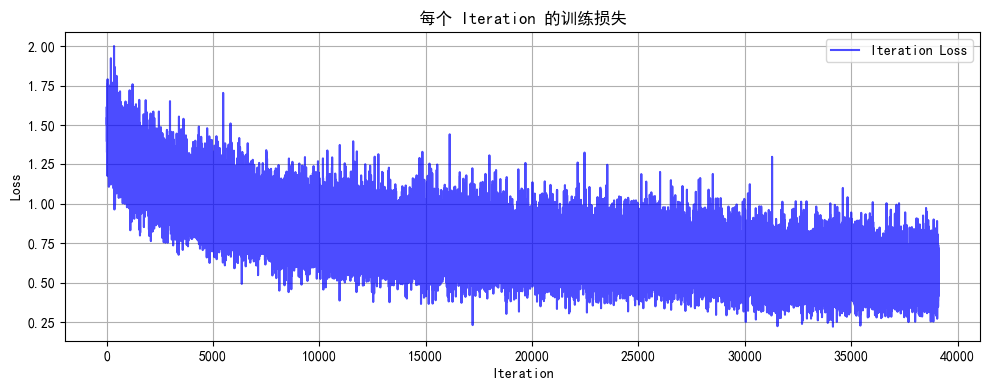

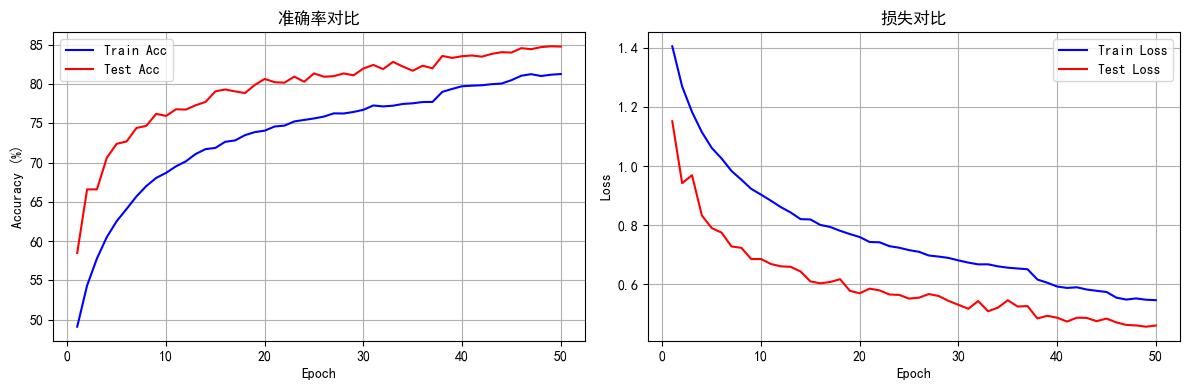

训练完成，测试准确率: 84.74%


In [6]:
def plot_iter_losses(losses, indices):
    plt.figure(figsize=(10, 4))
    plt.plot(indices, losses, 'b-', alpha=0.7, label='Iteration Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('每个 Iteration 的训练损失')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

def plot_epoch_metrics(train_acc, test_acc, train_loss, test_loss):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b-', label='Train Acc')
    plt.plot(epochs, test_acc, 'r-', label='Test Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('准确率对比'); plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b-', label='Train Loss')
    plt.plot(epochs, test_loss, 'r-', label='Test Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('损失对比'); plt.legend(); plt.grid(True)

    plt.tight_layout(); plt.show()

def train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    model.train()
    all_iter_losses, iter_indices = [], []
    train_acc_history, test_acc_history = [], []
    train_loss_history, test_loss_history = [], []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            iter_loss = loss.item()
            all_iter_losses.append(iter_loss)
            iter_indices.append(epoch * len(train_loader) + batch_idx + 1)

            running_loss += iter_loss
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs} | Batch {batch_idx+1}/{len(train_loader)} | 损失: {iter_loss:.4f}')

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct / total
        train_acc_history.append(epoch_train_acc)
        train_loss_history.append(epoch_train_loss)

        model.eval()
        test_loss = correct_test = total_test = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()

        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100. * correct_test / total_test
        test_acc_history.append(epoch_test_acc)
        test_loss_history.append(epoch_test_loss)

        scheduler.step(epoch_test_loss)
        model.train()
        print(f'Epoch {epoch+1}/{epochs} 完成 | 训练 Acc: {epoch_train_acc:.2f}% | 测试 Acc: {epoch_test_acc:.2f}%')

    plot_iter_losses(all_iter_losses, iter_indices)
    plot_epoch_metrics(train_acc_history, test_acc_history, train_loss_history, test_loss_history)
    return test_acc_history[-1]

print("开始训练基线 CNN...")
baseline_acc = train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs=50)
print(f"训练完成，测试准确率: {baseline_acc:.2f}%")

## 3. 卷积层特征图可视化
步骤：
1. 为目标层注册 forward hook 捕获输出
2. 取少量样本前向传播
3. 展示每层前若干通道的特征图，与原图对齐

小贴士：浅层更像“纹理/边缘”，深层更抽象更难解读。

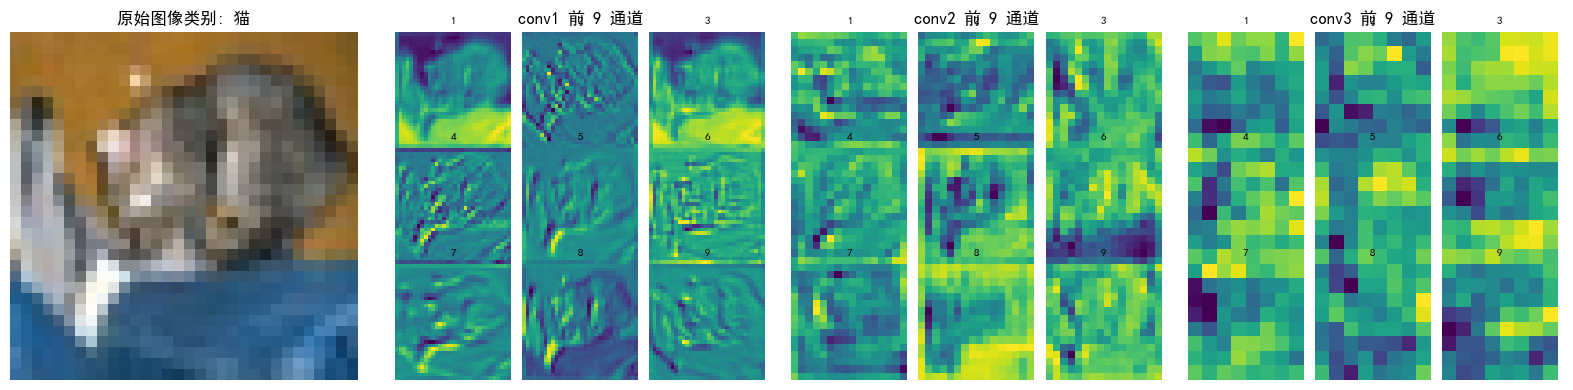

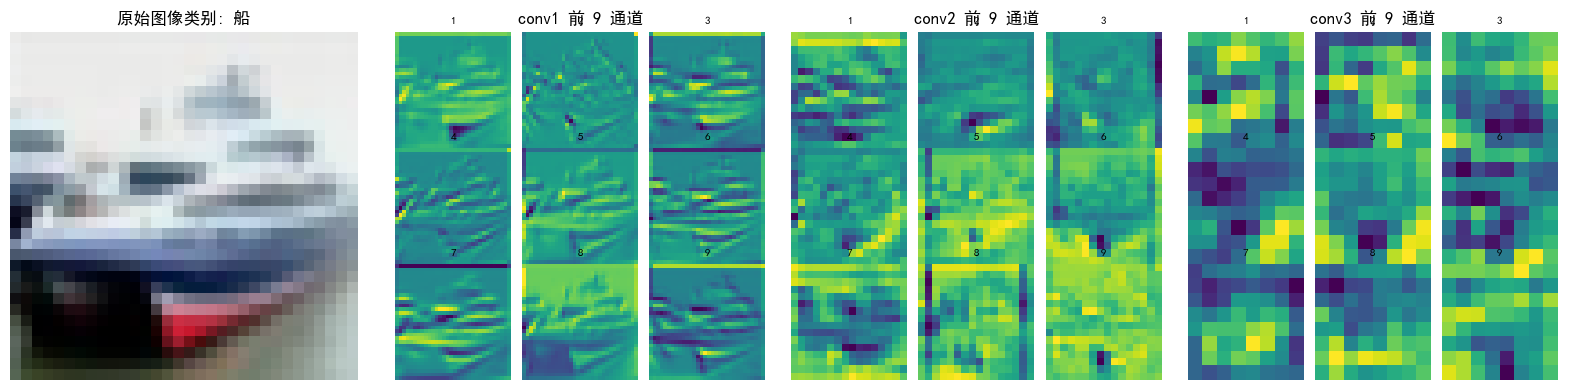

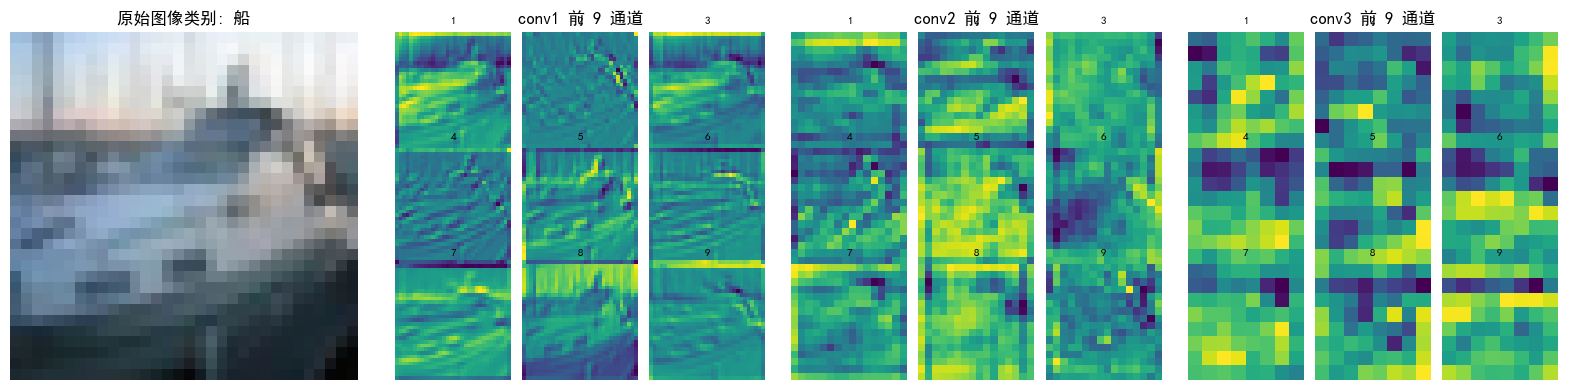

In [8]:
def visualize_feature_maps(model, test_loader, device, layer_names, num_images=3, num_channels=9):
    model.eval()
    images_list, labels_list = [], []
    for images, labels in test_loader:
        images_list.append(images)
        labels_list.append(labels)
        if len(images_list) * test_loader.batch_size >= num_images:
            break
    images = torch.cat(images_list, dim=0)[:num_images].to(device)
    labels = torch.cat(labels_list, dim=0)[:num_images].to(device)

    feature_maps = {}
    hooks = []
    def hook(module, input, output, name):
        feature_maps[name] = output.cpu()
    for name in layer_names:
        module = getattr(model, name)
        hooks.append(module.register_forward_hook(lambda m, i, o, n=name: hook(m, i, o, n)))

    _ = model(images)
    for h in hooks:
        h.remove()

    for img_idx in range(num_images):
        img = images[img_idx].cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.2023, 0.1994, 0.2010]).reshape(1, 1, 3) + np.array([0.4914, 0.4822, 0.4465]).reshape(1, 1, 3)
        img = np.clip(img, 0, 1)

        num_layers = len(layer_names)
        fig, axes = plt.subplots(1, num_layers + 1, figsize=(4 * (num_layers + 1), 4))

        axes[0].imshow(img)
        axes[0].set_title(f'原始图像类别: {class_names[labels[img_idx]]}')
        axes[0].axis('off')

        for layer_idx, layer_name in enumerate(layer_names):
            fm = feature_maps[layer_name][img_idx][:num_channels]
            num_rows = int(np.sqrt(num_channels))
            num_cols = num_channels // num_rows if num_rows else 1
            layer_ax = axes[layer_idx + 1]
            layer_ax.set_title(f'{layer_name} 前 {num_channels} 通道')
            layer_ax.axis('off')
            for ch_idx, channel in enumerate(fm):
                ax = layer_ax.inset_axes([
                    ch_idx % num_cols / num_cols,
                    (num_rows - 1 - ch_idx // num_cols) / num_rows,
                    1 / num_cols,
                    1 / num_rows,
                ])
                ax.imshow(channel.detach().numpy(), cmap='viridis')
                ax.set_title(f'{ch_idx + 1}', fontsize=8)
                ax.axis('off')
        plt.tight_layout(); plt.show()

layer_names = ['conv1', 'conv2', 'conv3']
visualize_feature_maps(model, test_loader, device, layer_names, num_images=3, num_channels=9)

## 4. 通道注意力（SE）
核心流程：
1. **Squeeze**：全局平均池化得到每个通道的整体响应
2. **Excitation**：两层全连接学习通道权重（0-1）
3. **Re-weight**：按权重重标定特征图，强化重要通道，抑制无关通道

轻量、易插拔，适合与卷积块搭配。

In [9]:
class ChannelAttention(nn.Module):
    """Squeeze-and-Excitation 通道注意力"""
    def __init__(self, in_channels, reduction_ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

### 4.1 将 SE 插入 CNN
- 在每个卷积块后加入 `ChannelAttention`
- 其余结构保持不变，便于做消融对比

开始训练带 SE 的 CNN...
Epoch 1/50 | Batch 100/782 | 损失: 1.8605
Epoch 1/50 | Batch 200/782 | 损失: 1.8923
Epoch 1/50 | Batch 300/782 | 损失: 1.6465
Epoch 1/50 | Batch 400/782 | 损失: 1.5320
Epoch 1/50 | Batch 500/782 | 损失: 1.7046
Epoch 1/50 | Batch 600/782 | 损失: 1.8581
Epoch 1/50 | Batch 700/782 | 损失: 1.5583
Epoch 1/50 完成 | 训练 Acc: 39.81% | 测试 Acc: 54.43%
Epoch 2/50 | Batch 100/782 | 损失: 1.3893
Epoch 2/50 | Batch 200/782 | 损失: 1.1986
Epoch 2/50 | Batch 300/782 | 损失: 1.4215
Epoch 2/50 | Batch 400/782 | 损失: 1.3086
Epoch 2/50 | Batch 500/782 | 损失: 1.1896
Epoch 2/50 | Batch 600/782 | 损失: 1.3483
Epoch 2/50 | Batch 700/782 | 损失: 1.4361
Epoch 2/50 完成 | 训练 Acc: 51.63% | 测试 Acc: 61.91%
Epoch 3/50 | Batch 100/782 | 损失: 1.2829
Epoch 3/50 | Batch 200/782 | 损失: 1.2434
Epoch 3/50 | Batch 300/782 | 损失: 1.3499
Epoch 3/50 | Batch 400/782 | 损失: 0.9461
Epoch 3/50 | Batch 500/782 | 损失: 1.1925
Epoch 3/50 | Batch 600/782 | 损失: 1.2802
Epoch 3/50 | Batch 700/782 | 损失: 1.1045
Epoch 3/50 完成 | 训练 Acc: 57.18% | 测试 Acc: 64.80

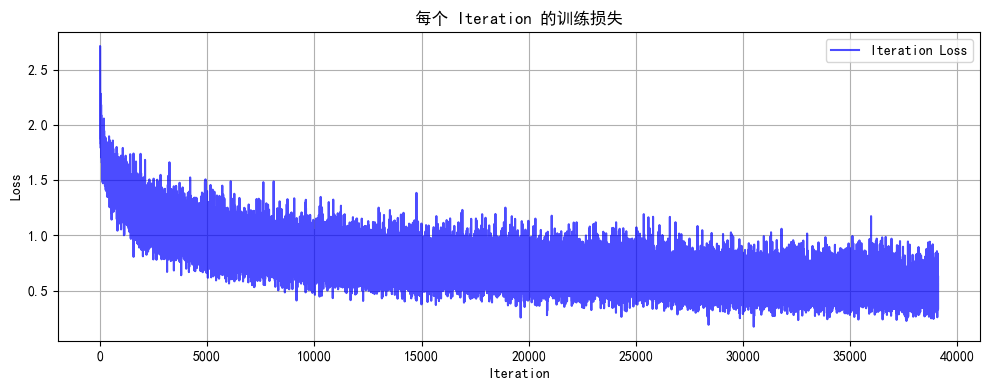

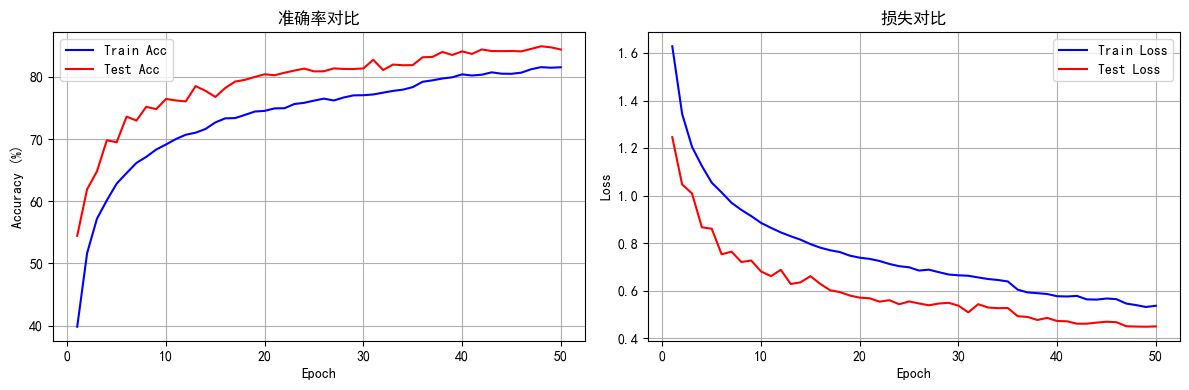

训练完成，测试准确率: 84.40%


In [10]:
class CNNWithSE(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.ca1 = ChannelAttention(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.ca2 = ChannelAttention(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.ca3 = ChannelAttention(128)
        self.pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(self.ca1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.pool2(self.ca2(self.relu2(self.bn2(self.conv2(x)))))
        x = self.pool3(self.ca3(self.relu3(self.bn3(self.conv3(x)))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.relu3(self.fc1(x)))
        return self.fc2(x)

model_se = CNNWithSE().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_se.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

print("开始训练带 SE 的 CNN...")
se_acc = train(model_se, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs=50)
print(f"训练完成，测试准确率: {se_acc:.2f}%")

> 消融解读：参数量略增，精度通常会有小幅提升；实际部署时要同时考虑推理时延。

## 5. 注意力热力图
- 钩住最后一个卷积层，获取特征图
- 使用平均池化估计通道权重，并选出最活跃通道
- 将特征图双线性插值回原尺寸，叠加到原图形成热力图
- 多通道对比：不同通道往往关注轮廓/纹理/颜色等不同模式

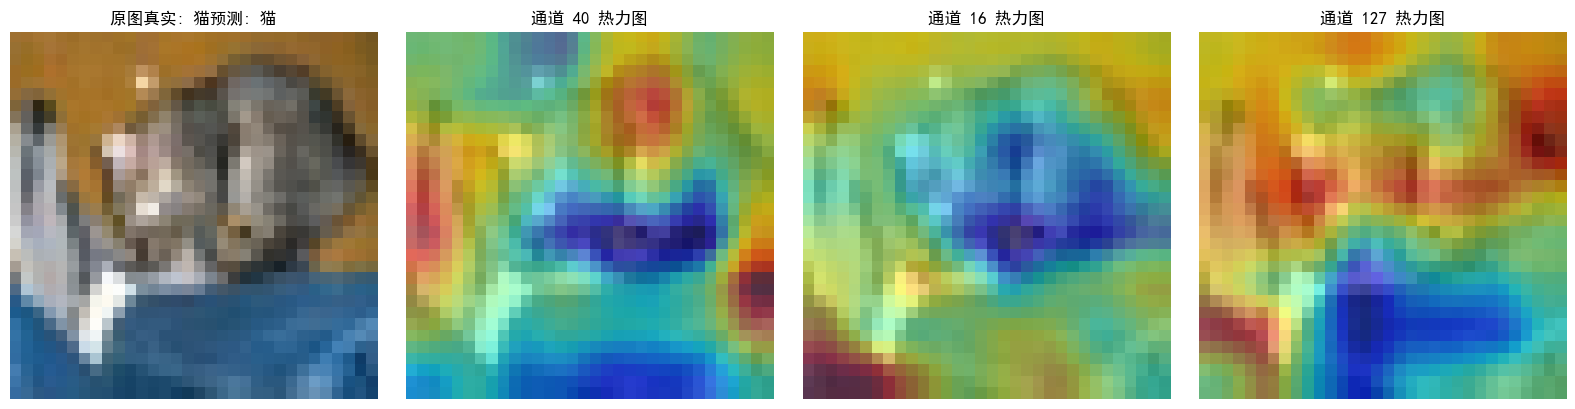

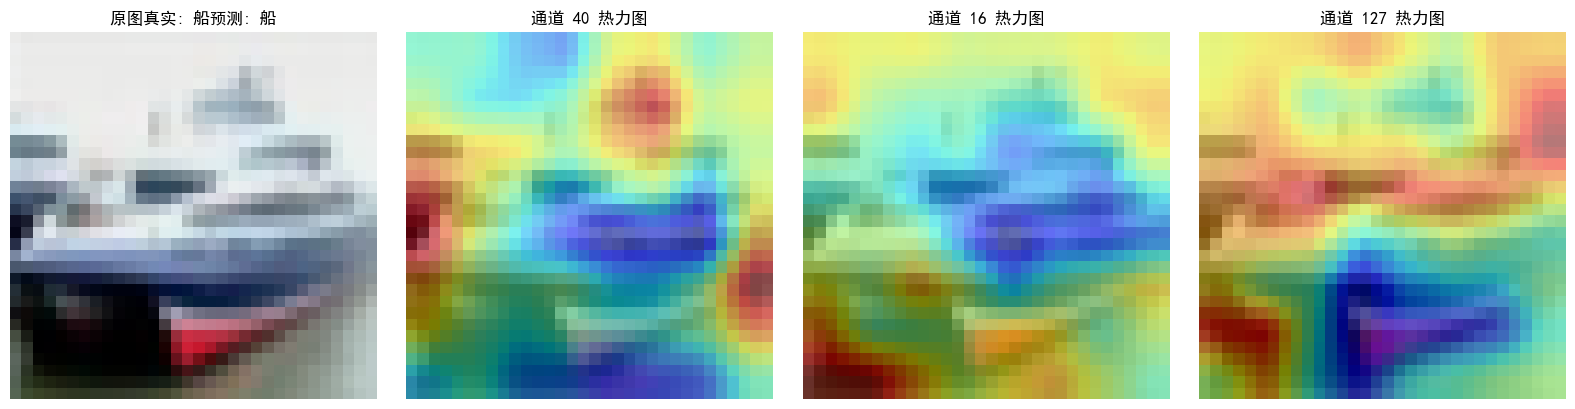

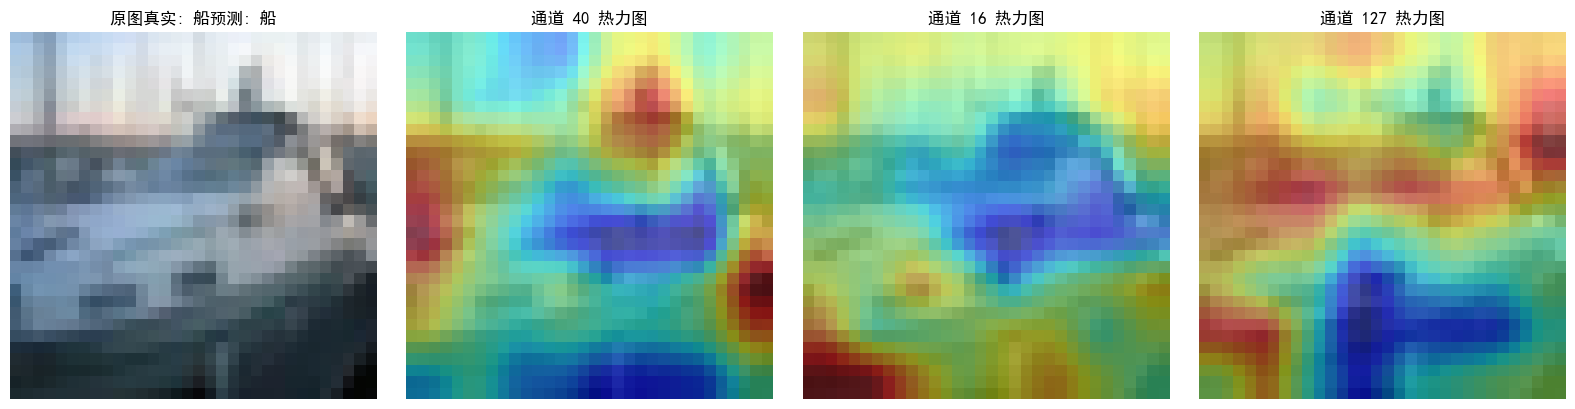

In [11]:
def visualize_attention_map(model, test_loader, device, class_names, num_samples=3):
    model.eval()
    shown = 0
    with torch.no_grad():
        for images, labels in test_loader:
            if shown >= num_samples:
                break
            images, labels = images.to(device), labels.to(device)

            activation_maps = []
            def hook(module, input, output):
                activation_maps.append(output.cpu())
            handle = model.conv3.register_forward_hook(hook)

            outputs = model(images)
            handle.remove()

            _, predicted = torch.max(outputs, 1)
            feature_map = activation_maps[0][0]  # 取第一个样本的特征图

            for idx in range(min(images.size(0), num_samples - shown)):
                img = images[idx].cpu().permute(1, 2, 0).numpy()
                img = img * np.array([0.2023, 0.1994, 0.2010]).reshape(1, 1, 3) + np.array([0.4914, 0.4822, 0.4465]).reshape(1, 1, 3)
                img = np.clip(img, 0, 1)

                # 计算通道权重并排序
                channel_weights = torch.mean(feature_map, dim=(1, 2))
                sorted_indices = torch.argsort(channel_weights, descending=True)

                fig, axes = plt.subplots(1, 4, figsize=(16, 4))
                axes[0].imshow(img)
                axes[0].set_title(f'原图真实: {class_names[labels[idx]]}预测: {class_names[predicted[idx]]}')
                axes[0].axis('off')

                for j in range(3):
                    ch_idx = sorted_indices[j]
                    ch_map = feature_map[ch_idx].unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
                    heatmap = F.interpolate(ch_map, size=(32, 32), mode='bilinear', align_corners=False).squeeze().numpy()
                    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

                    axes[j + 1].imshow(img)
                    axes[j + 1].imshow(heatmap, alpha=0.5, cmap='jet')
                    axes[j + 1].set_title(f'通道 {int(ch_idx)} 热力图')
                    axes[j + 1].axis('off')

                plt.tight_layout(); plt.show()
                shown += 1
                if shown >= num_samples:
                    break

visualize_attention_map(model_se, test_loader, device, class_names, num_samples=3)